# GAN example 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Generator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h1 = F.elu(self.map1(x))
        h2 = F.elu(self.map2(h1))
        return self.map3(h2)
    
class Discriminator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h1 = F.elu(self.map1(x))
        h2 = F.elu(self.map2(h1))
        return torch.sigmoid(self.map3(h2))   
    


In [3]:
batch_size = 256 # 16개마다 weight update
learning_rate = 0.001
num_epochs = 5000
d_steps = 1
g_steps = 1

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

G = Generator(input_size=1, hidden_size=100, output_size = 1)
D = Discriminator(input_size=1, hidden_size=100, output_size=1)

loss_func = nn.BCELoss() # Binery Cross Entropy

G.to(device)
D.to(device)


# Optimizers
optimizer_G = torch.optim.Adam(G.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(D.parameters(), lr=learning_rate)


valid = Variable(torch.Tensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
fake = Variable(torch.Tensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

mu, sigma = 7, 3 # mean and standard deviation
input_mu, input_sigma = 0.0, 0.2


input_x = np.random.normal(input_mu, input_sigma, (1000,1))


x = Variable(torch.Tensor(input_x)).to(device)

before_y = G(x).to("cpu").data.numpy()




In [4]:
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. D를 진짜와 가짜 데이터로 훈련시킨다. 
        D.zero_grad()

        #  1A: 실제 데이터로 D를 훈련시킨다. 
        d_real_data = Variable(torch.Tensor(np.random.normal(mu, sigma, (batch_size,1)))).to(device)
        d_real_decision = D(d_real_data)
        d_real_error = loss_func(d_real_decision, valid)  # ones = true
        d_real_error.backward() # 마분값을 계산 / 저장하지만, 파라미터를 바꾸지는 않는다. 

        d_gen_input = Variable(torch.Tensor(np.random.normal(0, 1, (batch_size,1)))).to(device)
        d_fake_data = G(d_gen_input).detach()  # G가 훈련할 때 이 라벨들을 피하도록 빼버린다. 
        d_fake_decision = D(d_fake_data)
        d_fake_error = loss_func(d_fake_decision, fake)  # zeros = fake
        d_fake_error.backward()
        optimizer_D.step()     # 오직 D의 파라미터만 최적화한다. backward()로 게산된 저장된 미분값에 의해 바뀐다.

    for g_index in range(g_steps):
        # 2. D의 응답을 활용해서 G를 트레이닝 시킨다. (그렇지만 D를 이 라벨로 트레이닝 하지는 않는다. )
        G.zero_grad()

        gen_input = Variable(torch.Tensor(np.random.normal(input_mu, input_sigma, (batch_size,1)))).to(device)
        g_fake_data = G(gen_input)
        dg_fake_decision = D(g_fake_data)
        g_error = loss_func(dg_fake_decision, valid)  # 우리는 바보를 원하기 떄문에 모든 게 진짜 것 처럼 행동한다.

        g_error.backward()
        optimizer_G.step()  # 오직 G의 파라미터만 최적화한다. 
    if(epoch % 100 == 1):
        print("epoch : %f, d_real_error : %f ,d_fake_error : %f ,g_error : %f"%(epoch, d_real_error ,d_fake_error ,g_error) )
    

epoch : 1.000000, d_real_error : 0.474370 ,d_fake_error : 0.631085 ,g_error : 0.778616
epoch : 101.000000, d_real_error : 0.382890 ,d_fake_error : 1.388946 ,g_error : 0.306350
epoch : 201.000000, d_real_error : 0.592245 ,d_fake_error : 0.357558 ,g_error : 1.340146
epoch : 301.000000, d_real_error : 1.085403 ,d_fake_error : 0.540530 ,g_error : 0.879331
epoch : 401.000000, d_real_error : 0.457408 ,d_fake_error : 0.509301 ,g_error : 0.932008
epoch : 501.000000, d_real_error : 0.588308 ,d_fake_error : 1.044108 ,g_error : 0.446896
epoch : 601.000000, d_real_error : 0.771643 ,d_fake_error : 0.672223 ,g_error : 0.798356
epoch : 701.000000, d_real_error : 0.473021 ,d_fake_error : 0.483357 ,g_error : 1.093585
epoch : 801.000000, d_real_error : 0.455211 ,d_fake_error : 0.433445 ,g_error : 1.105274
epoch : 901.000000, d_real_error : 0.556928 ,d_fake_error : 0.952065 ,g_error : 1.752551
epoch : 1001.000000, d_real_error : 0.477551 ,d_fake_error : 0.430566 ,g_error : 1.033434
epoch : 1101.000000, d

In [5]:


t = np.arange(-1, 1, 0.001)

gen_input = Variable(torch.Tensor(np.resize(t,(np.size(t),1)))).to(device)
g_fake_data = G(gen_input).to("cpu").data.numpy()

y = t*sigma+mu

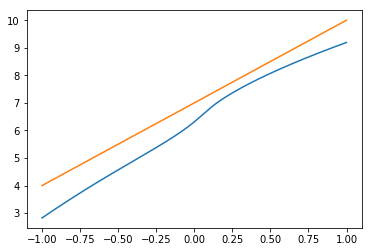

In [6]:
plt.plot(t,g_fake_data,t,y)

plt.show()

# hostogram exmaple

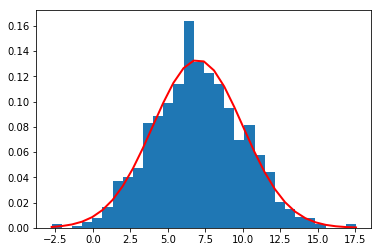

In [7]:
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.show()


# compare GAN histogram


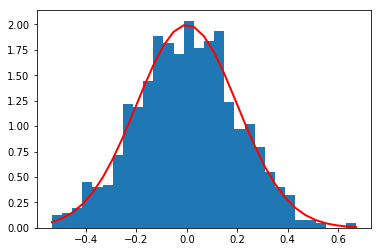

In [8]:

#input_x = np.random.normal(input_mu, input_sigma, (1000,1))

s = input_x
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(input_sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - input_mu)**2 / (2 * input_sigma**2) ),linewidth=2, color='r')
plt.show()

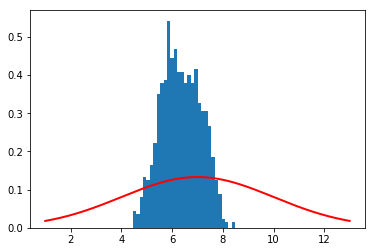

In [11]:

t = np.arange(mu-2*sigma, mu+2*sigma, 0.001)

x = Variable(torch.Tensor(input_x)).to(device)

y= G(x).to("cpu").data.numpy()

s = y
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(t, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (t - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.show()



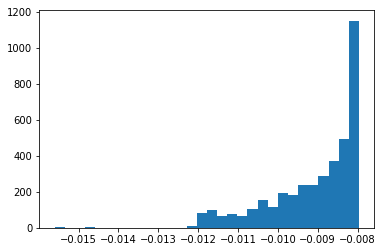

In [10]:
s = before_y
count, bins, ignored = plt.hist(s, 30, density=True)
#plt.plot(t, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (t - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.show()

